# **Melanoma Detection Assignment (IIIT Banglore_2022)**

## **By Ashwini Abhang**

## Problem Statement
#### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



In [ ]:
! pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the necessary dependencies

In [ ]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import warnings
warnings.filterwarnings("ignore") 

import Augmentor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img


## Data Reading/Data Understanding

In [ ]:
#Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train")
data_test = pathlib.Path('/content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Test')

In [ ]:
# Counting the number of images in train and test datasets

# Images from train dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

# Images from test dataset
image_count_test = len(list(data_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

## Dataset Creation

In [ ]:
#Creating train dataset. Here we use tf.keras.preprocessing.image_dataset_from_directory to generate train dataset
## Make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=42,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
#Creating validation dataset. Here we use tf.keras.preprocessing.image_dataset_from_directory to generate validation dataset
## Make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=42,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


## Dataset visualisation

Found 2239 files belonging to 9 classes.


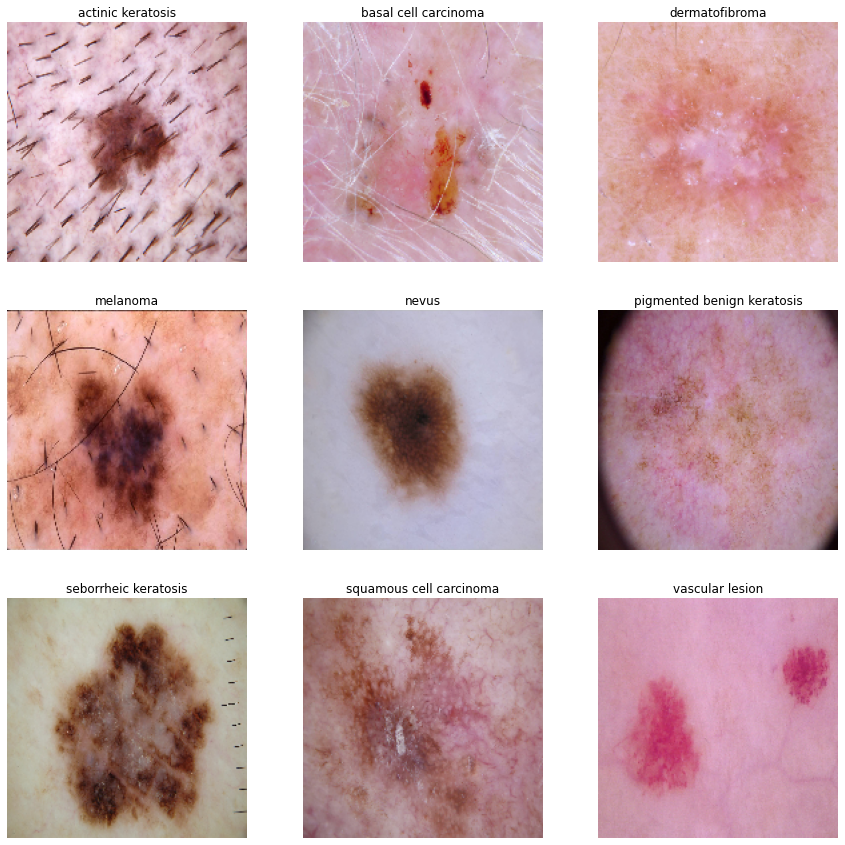

In [ ]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [ ]:
# Printing the class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
## Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

## Dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building & training 

### Model Creation

In [ ]:
## Creating a CNN model with 3 Convolution layers 

# Sequential groups a linear stack of layers into a model
model = Sequential()
# Using layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). 
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Model Compilation

In [ ]:
## Compile is used to configure the model with appropriate optimizer, loss function and metrics 
# Here the optimizer is adam with loss as Sparse Categorical Crossentropy and metrics as accuracy

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model 

Epochs = 20 

In [ ]:

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 306s 1s/step - loss: 2.0222 - accuracy: 0.2444 - val_loss: 1.8158 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 2s 44ms/step - loss: 1.7138 - accuracy: 0.3873 - val_loss: 1.6182 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6094 - accuracy: 0.4431 - val_loss: 1.6033 - val_accuracy: 0.4206
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5194 - accuracy: 0.4593 - val_loss: 1.3742 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 2s 44ms/step - loss: 1.3986 - accuracy: 0.5073 - val_loss: 1.4993 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3416 - accuracy: 0.5290 - val_loss: 1.3215 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.2984 - accuracy: 0.5385 - val_loss: 1.3572 - val_accuracy: 0.5324
Epoch 8/20
56

### Visualzing the Results

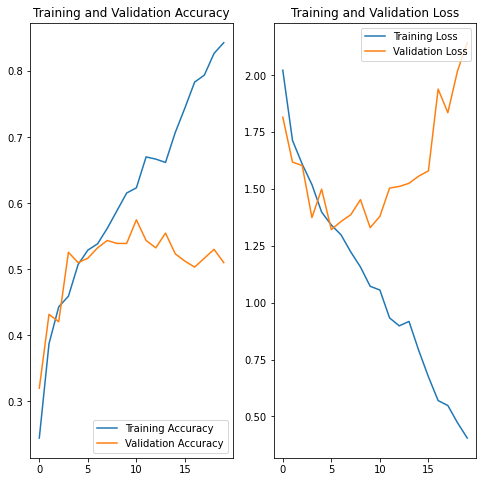

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations from Model Creation and Building
- From the visualizations it can be observed that the validation loss is increasing as the epochs increase.
- Indicating that the model is overfitting.
- To solve this issue I try to augment the data 

## Data Augmentation

In [ ]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomContrast(factor = 1),
                             layers.experimental.preprocessing.RandomTranslation(height_factor=0.2,  width_factor=0.2,fill_mode='reflect', interpolation='bilinear',seed=42,fill_value=0.0,)
])

### Visualising the Augmented Data

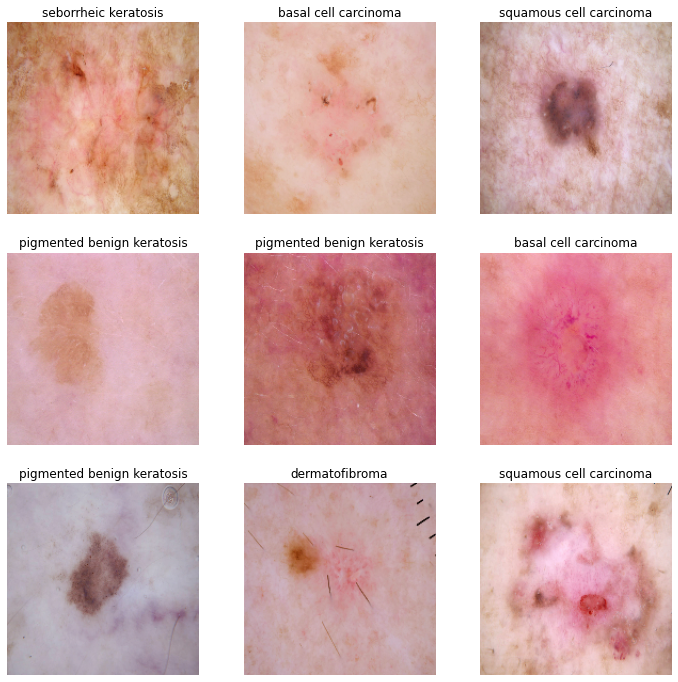

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Model Building & Training on the Augmented Data 

### Model Creation

In [ ]:
num_classes = 9
## Creating a CNN model with 3 Convolution layers 

# Sequential groups a linear stack of layers into a model
# Using layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). 
model = Sequential([data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


### Model Compilation

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the Model

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 51ms/step - loss: 2.0988 - accuracy: 0.2288 - val_loss: 1.7710 - val_accuracy: 0.3714
Epoch 2/20
56/56 [==============================] - 3s 48ms/step - loss: 1.8795 - accuracy: 0.2963 - val_loss: 1.6142 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 3s 48ms/step - loss: 1.6875 - accuracy: 0.3867 - val_loss: 1.5185 - val_accuracy: 0.4609
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6711 - accuracy: 0.3984 - val_loss: 1.4811 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 3s 48ms/step - loss: 1.6384 - accuracy: 0.4062 - val_loss: 1.4654 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 3s 48ms/step - loss: 1.6462 - accuracy: 0.4102 - val_loss: 1.6361 - val_accuracy: 0.3826
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6026 - accuracy: 0.4308 - val_loss: 1.5106 - val_accuracy: 0.4586
Epoch 8/20
56

### Visualsing the Results

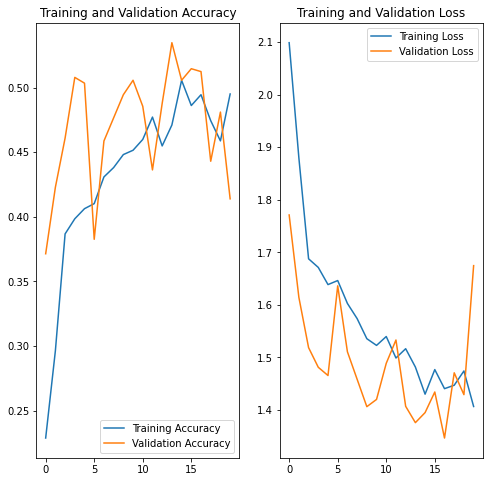

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation from the Model Building and Training of Augmented Data

- From the visualizations it is quite clear that the data augmentation has reduced overfitting to quite an extent.

- But this augmentation has also reduced the training accuracy in the process.

- I will now check the distribution of the dataset.

## Examining the Class Distribution 

In [ ]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
1,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
2,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
3,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
4,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion
2235,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion
2236,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion
2237,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion


In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
1,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
2,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
3,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
4,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion
2235,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion
2236,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion
2237,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion


### Checking the number of images per class (Disease)

In [ ]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,nevus,357
1,pigmented benign keratosis,462
2,melanoma,438
3,seborrheic keratosis,77
4,basal cell carcinoma,376
5,vascular lesion,139
6,dermatofibroma,95
7,actinic keratosis,114
8,squamous cell carcinoma,181


### Visualizing the results of class distribution

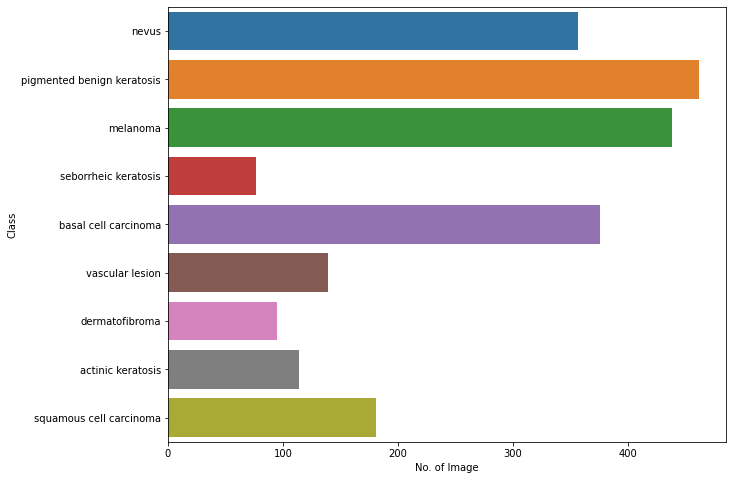

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

### *Observations from Class Distribution Examination*

- All the classes have different number of images. Therefore the dataset is imbalanced.

- Pigmented Benign Keratosis has the maximum number of images -	462

- Seborrheic Keratosis has the minimum number of images -	77

## Rectifying the Class Imbalance 

#### Here I will be using the Augmentor Library to rectify the class imbalance. It will add more samples across all classes so that none of the classes have very few samples.

To use Augmentor, the following general procedure is followed:

- Instantiate a Pipeline object pointing to a directory containing your initial image data set.

- Define a number of operations to perform on this data set using your Pipeline object.

- Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
## Initialising the Augmentor 
### Defining the path of images which will be used by augmentor

path_to_training_dataset="/content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/"

## We are adding 500 samples per class to make sure that none of the classes are sparse.

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+i,save_format='jpg')
    
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
	  
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7BF6844E50>: 100%|██████████| 500/500 [00:21<00:00, 23.45 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7D159394D0>: 100%|██████████| 500/500 [00:21<00:00, 23.61 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7BF43E09D0>: 100%|██████████| 500/500 [00:18<00:00, 26.91 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=722x540 at 0x7F7BF437FFD0>: 100%|██████████| 500/500 [01:24<00:00,  5.93 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F7C8CD41990>: 100%|██████████| 500/500 [01:08<00:00,  7.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7BF7316B50>: 100%|██████████| 500/500 [00:18<00:00, 27.04 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F7C806AC610>: 100%|██████████| 500/500 [00:42<00:00, 11.82 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7BF721AFD0>: 100%|██████████| 500/500 [00:18<00:00, 27.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7C80705510>: 100%|██████████| 500/500 [00:19<00:00, 25.35 Samples/s]


In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Observing the distribution of augmented data after adding new images to the original training data.

In [ ]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=42,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=42,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

## Model Building & training on the rectified class imbalance data

### Model Creation

In [ ]:
num_classes = 9
## Creating a CNN model with 3 Convolution layers 

# Sequential groups a linear stack of layers into a model
model = Sequential()

# Using layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). 
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

### Model Compilation

In [ ]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model-512-256-128.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
# Reduces learning rate when a metric has stopped improving. 
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

### Training the Model

In [ ]:
# Train the model
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 1.9706 - accuracy: 0.2454
Epoch 1: val_accuracy improved from -inf to 0.33482, saving model to model-512-256-128.h5
169/169 [==============================] - 32s 180ms/step - loss: 1.9706 - accuracy: 0.2454 - val_loss: 1.7038 - val_accuracy: 0.3348 - lr: 0.0010
Epoch 2/30
167/169 [============================>.] - ETA: 0s - loss: 1.5657 - accuracy: 0.4152
Epoch 2: val_accuracy improved from 0.33482 to 0.45805, saving model to model-512-256-128.h5
169/169 [==============================] - 30s 171ms/step - loss: 1.5663 - accuracy: 0.4151 - val_loss: 1.4571 - val_accuracy: 0.4581 - lr: 0.0010
Epoch 3/30
167/169 [============================>.] - ETA: 0s - loss: 1.3625 - accuracy: 0.4817
Epoch 3: val_accuracy improved from 0.45805 to 0.47439, saving model to model-512-256-128.h5
169/169 [==============================] - 30s 172ms/step - loss: 1.3617 - accuracy: 0.4822 - val_loss: 1.3699 - val_accuracy: 0.4744 - lr: 0.

### Visualizing the Results

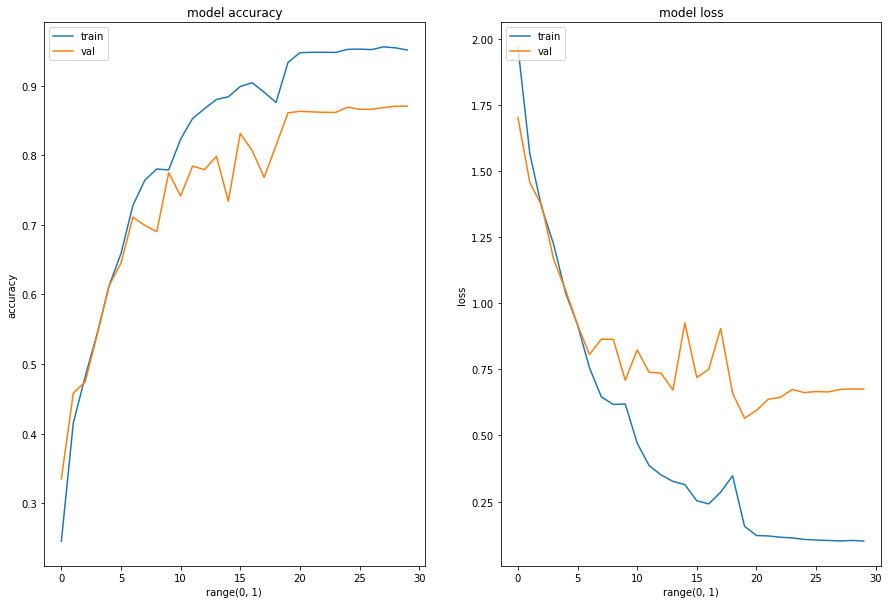

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### *Observation from Model Building & training on the rectified class imbalance data*

- It can be seen that after rectifying the data the overfiting has drastically reduced.

- It can also be seen that after balancing the class the validation accuracy and training accuracy have gone up. It is a great sign! 

- Hence the issue of overfitting and low accuracy have been resolved.


## Testing the model on Test Dataset

Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


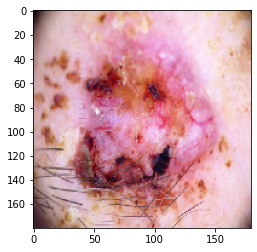

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-3],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

## **Conclsuion**
Hence I have been able to create a custom convolutional neural network for multiclass classification of skin cancer. Various issues arised during the training of the model such as overfitting and class imbalnace. Both these issues were resolved by using data augmentation and the augmentor library respectively.<br> The final _training accuracy_ is **95.16%** and a _validaton accuracy_ of **87.082%** 